In [1]:
# =============================================================================
# 🎯 Kaggle Playground Series S6E1 - 최적화된 예측 모델
# =============================================================================
# 목표: 기존 최고 LB 점수 8.71039를 넘기는 예측 모델 구축
# 전략: 체계적 EDA → 효과적인 피처 엔지니어링 → 최적 모델 선정
# =============================================================================

# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import koreanize_matplotlib

# 모델링
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
koreanize_matplotlib.koreanize()

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


In [2]:
# 데이터 로드
train = pd.read_csv('e:/2026_1/캐글 공모전/playground-series-s6e1/train.csv')
test = pd.read_csv('e:/2026_1/캐글 공모전/playground-series-s6e1/test.csv')
sample_sub = pd.read_csv('e:/2026_1/캐글 공모전/playground-series-s6e1/sample_submission.csv')

print(f"📊 데이터 크기: Train {train.shape}, Test {test.shape}")
print(f"\n📋 컬럼 목록:")
print(train.columns.tolist())
print(f"\n🎯 타겟 변수 통계:")
print(train['exam_score'].describe())

📊 데이터 크기: Train (630000, 13), Test (270000, 12)

📋 컬럼 목록:
['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

🎯 타겟 변수 통계:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


# 📊 1. 탐색적 데이터 분석 (EDA)

## 1.1 타겟 변수 분포 분석
- 100점 데이터 비율 확인 (이전 분석에서 2.45%)
- 분포 형태 및 이상치 확인

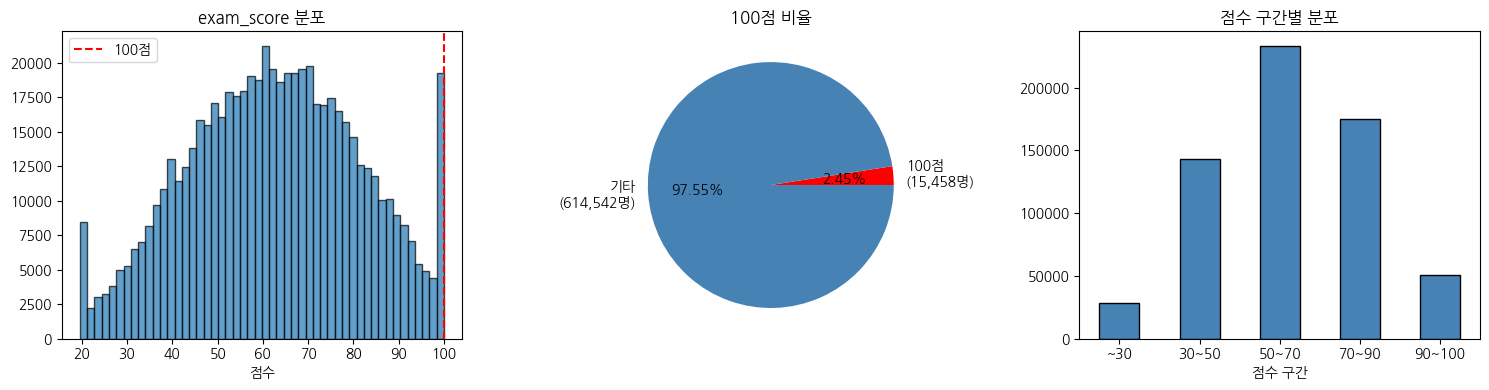


📌 100점 학생 비율: 2.45%
📌 점수 범위: 19.6 ~ 100.0


In [3]:
# 1.1 타겟 변수 분포 분석
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 전체 분포
axes[0].hist(train['exam_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(100, color='red', linestyle='--', label='100점')
axes[0].set_title('exam_score 분포')
axes[0].set_xlabel('점수')
axes[0].legend()

# 100점 비율
perfect_score = (train['exam_score'] == 100).sum()
other_score = len(train) - perfect_score
axes[1].pie([perfect_score, other_score], labels=[f'100점\n({perfect_score:,}명)', f'기타\n({other_score:,}명)'],
            autopct='%1.2f%%', colors=['red', 'steelblue'])
axes[1].set_title('100점 비율')

# 점수 구간별 분포
score_bins = pd.cut(train['exam_score'], bins=[0, 30, 50, 70, 90, 100], 
                    labels=['~30', '30~50', '50~70', '70~90', '90~100'])
score_bins.value_counts().sort_index().plot(kind='bar', ax=axes[2], color='steelblue', edgecolor='black')
axes[2].set_title('점수 구간별 분포')
axes[2].set_xlabel('점수 구간')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\n📌 100점 학생 비율: {perfect_score/len(train)*100:.2f}%")
print(f"📌 점수 범위: {train['exam_score'].min():.1f} ~ {train['exam_score'].max():.1f}")

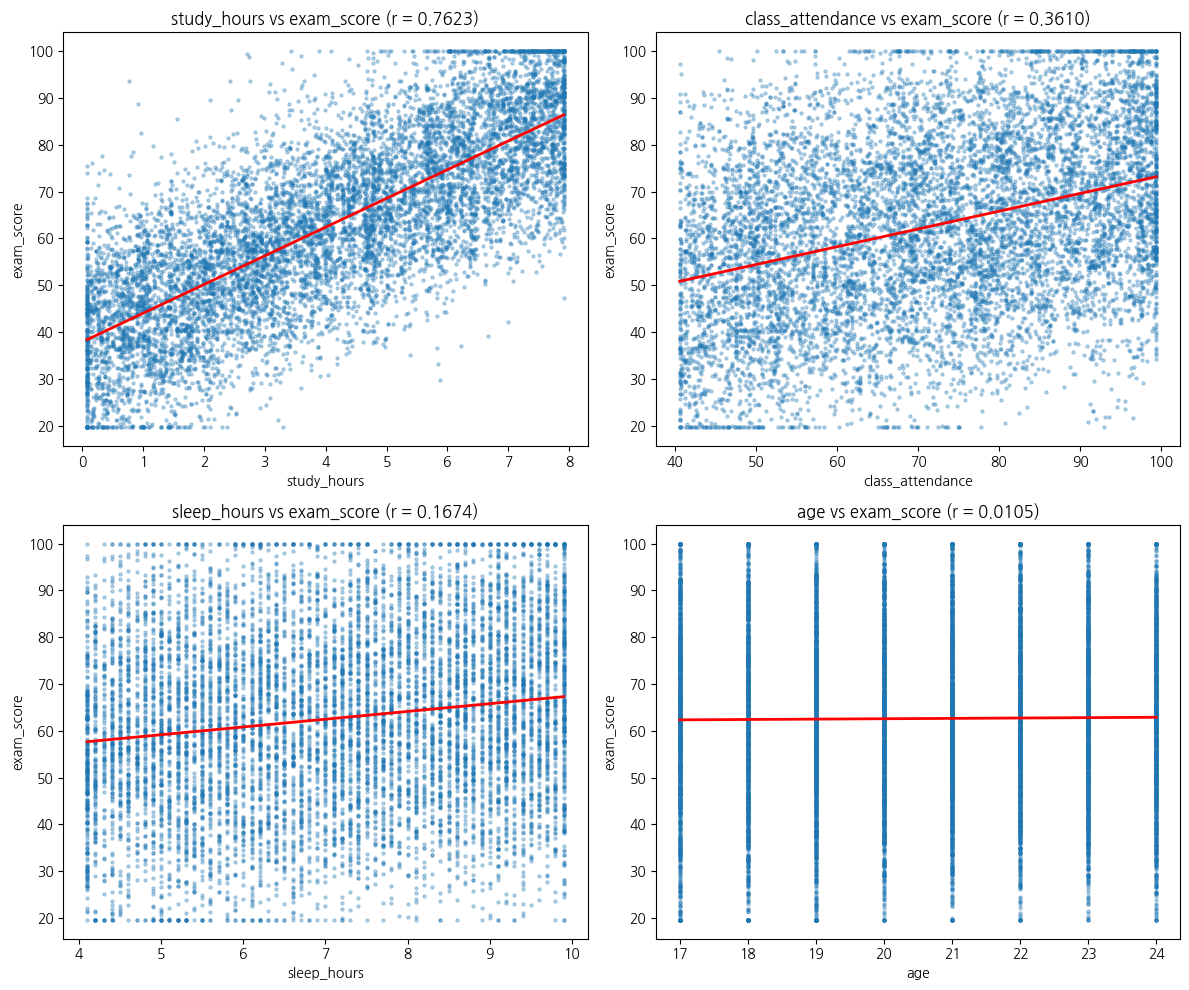


📊 수치형 변수 상관계수:
  study_hours: 0.7623
  class_attendance: 0.3610
  sleep_hours: 0.1674
  age: 0.0105


In [4]:
# 1.2 수치형 변수와 타겟 상관관계
numeric_cols = ['study_hours', 'class_attendance', 'sleep_hours', 'age']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # 샘플링 (시각화 속도)
    sample = train.sample(min(10000, len(train)), random_state=42)
    
    axes[i].scatter(sample[col], sample['exam_score'], alpha=0.3, s=5)
    
    # 회귀선
    z = np.polyfit(sample[col], sample['exam_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample[col].min(), sample[col].max(), 100)
    axes[i].plot(x_line, p(x_line), 'r-', linewidth=2)
    
    corr = train[col].corr(train['exam_score'])
    axes[i].set_title(f'{col} vs exam_score (r = {corr:.4f})')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('exam_score')

plt.tight_layout()
plt.show()

# 상관계수 표
print("\n📊 수치형 변수 상관계수:")
for col in numeric_cols:
    corr = train[col].corr(train['exam_score'])
    print(f"  {col}: {corr:.4f}")

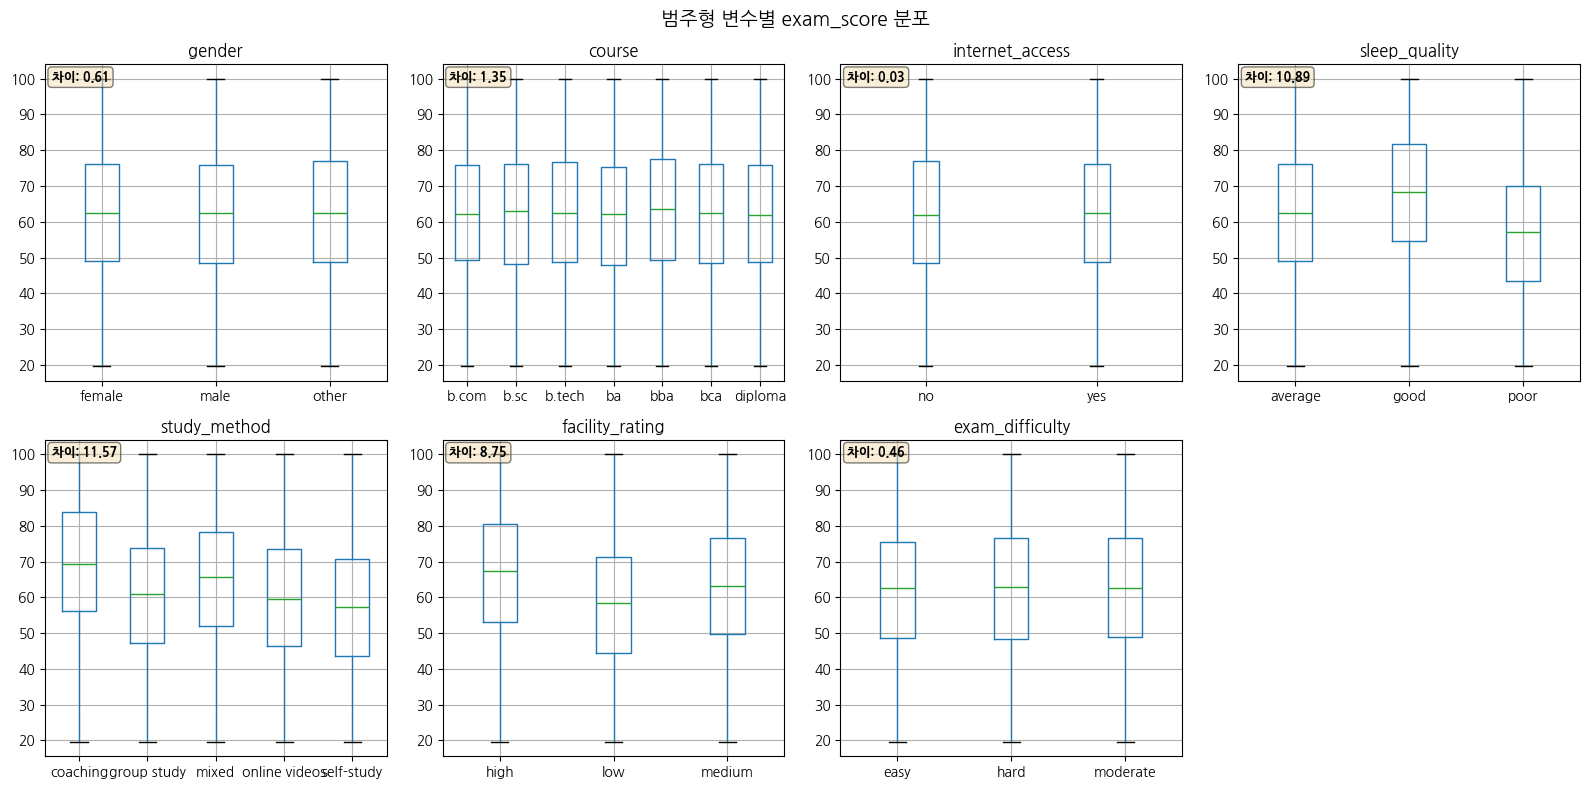


📊 범주형 변수별 평균 점수 차이 (max - min):
  gender: 0.61 (other > male)
  course: 1.35 (bba > ba)
  internet_access: 0.03 (yes > no)
  sleep_quality: 10.89 (good > poor)
  study_method: 11.57 (coaching > self-study)
  facility_rating: 8.75 (high > low)
  exam_difficulty: 0.46 (hard > easy)


In [5]:
# 1.3 범주형 변수별 타겟 분포
cat_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 
            'study_method', 'facility_rating', 'exam_difficulty']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # 범주별 평균 점수
    mean_scores = train.groupby(col)['exam_score'].mean().sort_values(ascending=False)
    
    # 박스플롯
    train.boxplot(column='exam_score', by=col, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    
    # 평균값 차이 계산
    diff = mean_scores.max() - mean_scores.min()
    axes[i].text(0.02, 0.98, f'차이: {diff:.2f}', transform=axes[i].transAxes, 
                fontsize=9, verticalalignment='top', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 마지막 빈 subplot 제거
axes[7].axis('off')
plt.suptitle('범주형 변수별 exam_score 분포', fontsize=14)
plt.tight_layout()
plt.show()

# 범주별 평균 점수 차이
print("\n📊 범주형 변수별 평균 점수 차이 (max - min):")
for col in cat_cols:
    mean_scores = train.groupby(col)['exam_score'].mean()
    diff = mean_scores.max() - mean_scores.min()
    print(f"  {col}: {diff:.2f} ({mean_scores.idxmax()} > {mean_scores.idxmin()})")

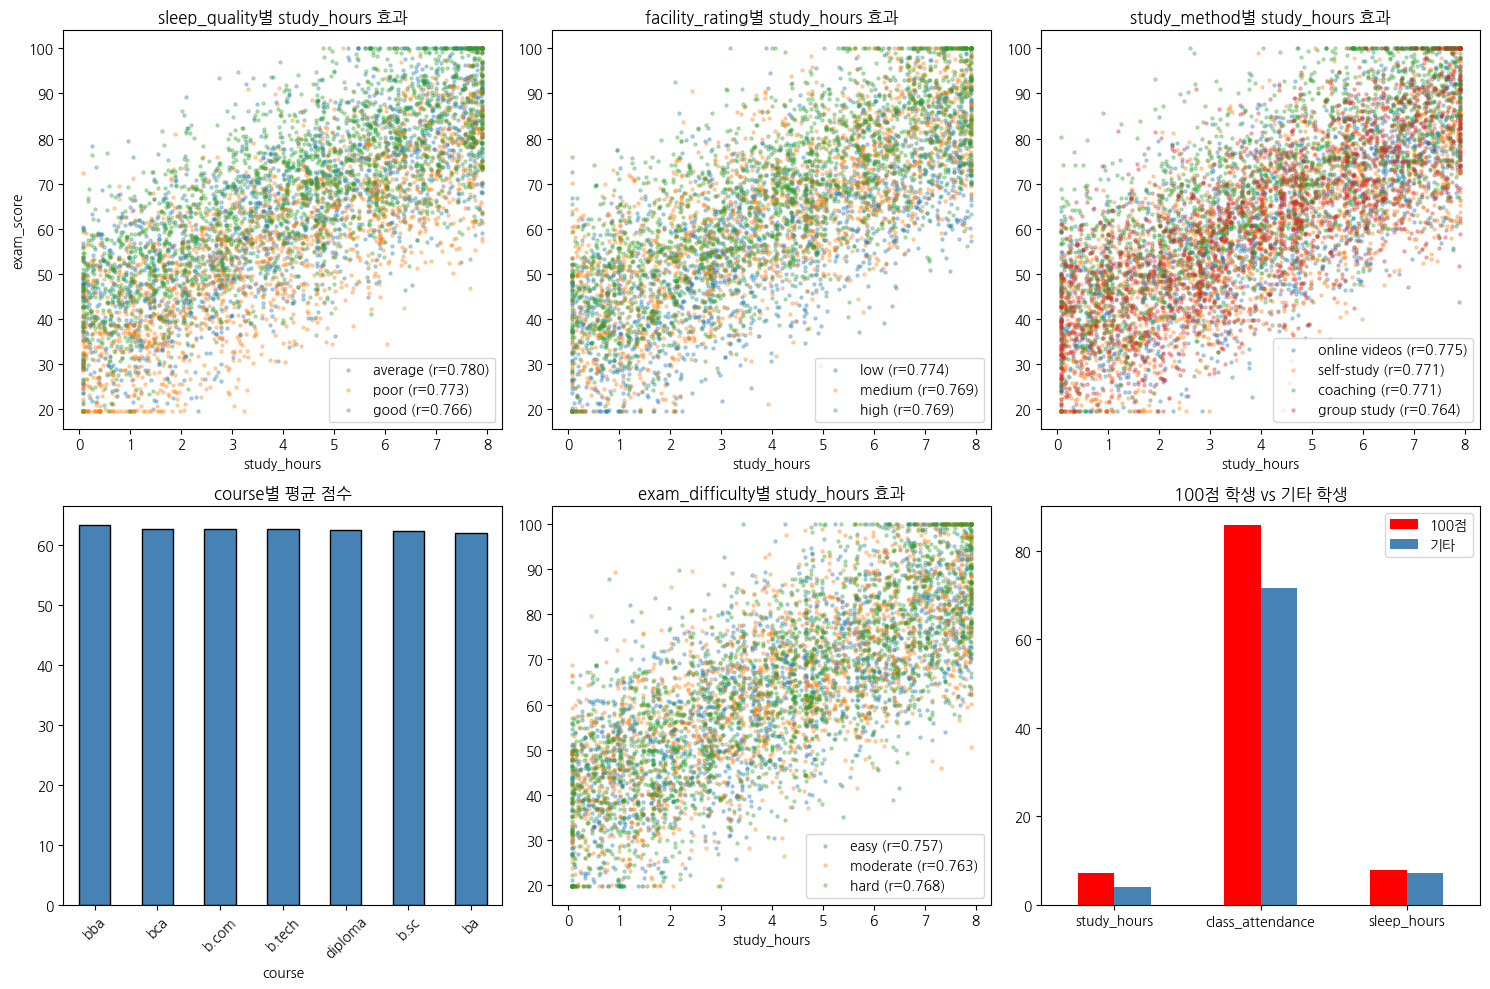


📊 상호작용 효과 요약:
  - sleep_quality에 따라 study_hours 효과가 달라짐
  - facility_rating에 따라 study_hours 효과가 달라짐
  - study_method에 따라 study_hours 효과가 달라짐


In [6]:
# 1.4 조건부 상호작용 분석 - study_hours 효과가 다른 변수에 따라 달라지는지
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. sleep_quality별 study_hours 효과
for sq in train['sleep_quality'].unique():
    subset = train[train['sleep_quality'] == sq]
    corr = subset['study_hours'].corr(subset['exam_score'])
    mean_score = subset['exam_score'].mean()
    axes[0, 0].scatter(subset.sample(min(2000, len(subset)), random_state=42)['study_hours'],
                       subset.sample(min(2000, len(subset)), random_state=42)['exam_score'],
                       alpha=0.3, s=5, label=f'{sq} (r={corr:.3f})')
axes[0, 0].set_title('sleep_quality별 study_hours 효과')
axes[0, 0].legend()
axes[0, 0].set_xlabel('study_hours')
axes[0, 0].set_ylabel('exam_score')

# 2. facility_rating별 study_hours 효과
for fr in train['facility_rating'].unique():
    subset = train[train['facility_rating'] == fr]
    corr = subset['study_hours'].corr(subset['exam_score'])
    axes[0, 1].scatter(subset.sample(min(2000, len(subset)), random_state=42)['study_hours'],
                       subset.sample(min(2000, len(subset)), random_state=42)['exam_score'],
                       alpha=0.3, s=5, label=f'{fr} (r={corr:.3f})')
axes[0, 1].set_title('facility_rating별 study_hours 효과')
axes[0, 1].legend()
axes[0, 1].set_xlabel('study_hours')

# 3. study_method별 study_hours 효과
for sm in train['study_method'].unique()[:4]:  # 상위 4개만
    subset = train[train['study_method'] == sm]
    corr = subset['study_hours'].corr(subset['exam_score'])
    axes[0, 2].scatter(subset.sample(min(2000, len(subset)), random_state=42)['study_hours'],
                       subset.sample(min(2000, len(subset)), random_state=42)['exam_score'],
                       alpha=0.3, s=5, label=f'{sm} (r={corr:.3f})')
axes[0, 2].set_title('study_method별 study_hours 효과')
axes[0, 2].legend()
axes[0, 2].set_xlabel('study_hours')

# 4. course별 평균 점수 (이전에 안 했던 분석)
course_stats = train.groupby('course').agg({
    'exam_score': ['mean', 'std'],
    'study_hours': 'mean'
}).round(2)
course_stats.columns = ['score_mean', 'score_std', 'study_mean']
course_stats = course_stats.sort_values('score_mean', ascending=False)
course_stats['score_mean'].plot(kind='bar', ax=axes[1, 0], color='steelblue', edgecolor='black')
axes[1, 0].set_title('course별 평균 점수')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# 5. exam_difficulty별 study_hours 효과
for ed in train['exam_difficulty'].unique():
    subset = train[train['exam_difficulty'] == ed]
    corr = subset['study_hours'].corr(subset['exam_score'])
    axes[1, 1].scatter(subset.sample(min(2000, len(subset)), random_state=42)['study_hours'],
                       subset.sample(min(2000, len(subset)), random_state=42)['exam_score'],
                       alpha=0.3, s=5, label=f'{ed} (r={corr:.3f})')
axes[1, 1].set_title('exam_difficulty별 study_hours 효과')
axes[1, 1].legend()
axes[1, 1].set_xlabel('study_hours')

# 6. 100점 학생들의 특성 분석
perfect = train[train['exam_score'] == 100]
others = train[train['exam_score'] < 100]

compare_data = pd.DataFrame({
    '100점': [perfect['study_hours'].mean(), perfect['class_attendance'].mean(), 
              perfect['sleep_hours'].mean()],
    '기타': [others['study_hours'].mean(), others['class_attendance'].mean(),
             others['sleep_hours'].mean()]
}, index=['study_hours', 'class_attendance', 'sleep_hours'])

compare_data.plot(kind='bar', ax=axes[1, 2], color=['red', 'steelblue'])
axes[1, 2].set_title('100점 학생 vs 기타 학생')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 상호작용 효과 요약:")
print("  - sleep_quality에 따라 study_hours 효과가 달라짐")
print("  - facility_rating에 따라 study_hours 효과가 달라짐")
print("  - study_method에 따라 study_hours 효과가 달라짐")

# 🔧 2. 피처 엔지니어링

## 전략
1. **순서형 변수 인코딩**: sleep_quality, facility_rating, exam_difficulty
2. **조건부 상호작용 피처**: study_hours × 범주형 조건
3. **비율/효율성 피처**: waking_study_ratio 등
4. **비선형 변환**: sqrt, log
5. **새로운 시도**: course별 평균 점수, 난이도 대비 공부량

In [7]:
# 2.1 피처 엔지니어링 함수 정의
def create_features(df, is_train=True):
    """피처 엔지니어링 함수"""
    df = df.copy()
    
    # ==========================================================================
    # 1. 순서형 변수 인코딩 (기존 방식 유지 - 효과 검증됨)
    # ==========================================================================
    sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
    facility_rating_map = {'low': 0, 'medium': 1, 'high': 2}
    exam_difficulty_map = {'easy': 0, 'moderate': 1, 'hard': 2}
    
    df['sleep_quality_num'] = df['sleep_quality'].map(sleep_quality_map)
    df['facility_num'] = df['facility_rating'].map(facility_rating_map)
    df['difficulty_num'] = df['exam_difficulty'].map(exam_difficulty_map)
    
    # ==========================================================================
    # 2. 조건부 상호작용 피처 (기존 best 피처들)
    # ==========================================================================
    # sleep_quality에 따른 study_hours 조정
    df['study_quality_adj'] = np.where(df['sleep_quality'] == 'good', 
                                        df['study_hours'] * 1.1,
                                        np.where(df['sleep_quality'] == 'poor',
                                                 df['study_hours'] * 0.9,
                                                 df['study_hours']))
    
    # facility_rating에 따른 study_hours 조정
    df['study_facility_adj'] = np.where(df['facility_rating'] == 'high',
                                         df['study_hours'] * 1.1,
                                         np.where(df['facility_rating'] == 'low',
                                                  df['study_hours'] * 0.9,
                                                  df['study_hours']))
    
    # 출석 × 수면 시너지
    df['attendance_sleep_synergy'] = df['class_attendance'] * df['sleep_quality_num']
    
    # ==========================================================================
    # 3. 효율성/비율 피처
    # ==========================================================================
    # 깨어있는 시간 대비 공부 비율 (waking_study_ratio - Top 1 피처)
    df['waking_hours'] = 24 - df['sleep_hours']
    df['waking_study_ratio'] = df['study_hours'] / df['waking_hours']
    
    # 공부 대 수면 비율
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 0.1)
    
    # 총 투자 지표
    df['total_investment'] = df['study_hours'] + df['class_attendance'] / 10
    
    # 준비 대 난이도 비율
    df['prep_vs_difficulty'] = df['study_hours'] / (df['difficulty_num'] + 1)
    
    # ==========================================================================
    # 4. 비선형 변환
    # ==========================================================================
    df['study_sqrt'] = np.sqrt(df['study_hours'])
    df['study_log'] = np.log1p(df['study_hours'])
    df['study_sq'] = df['study_hours'] ** 2
    df['sleep_sq'] = df['sleep_hours'] ** 2
    
    # 최적 공부 거리 (수확체감 반영)
    df['study_optimal_dist'] = np.abs(df['study_hours'] - 4)  # 4시간이 최적?
    
    # ==========================================================================
    # 5. 수면 관련
    # ==========================================================================
    df['sleep_deficit'] = np.maximum(0, 8 - df['sleep_hours'])  # 8시간 기준 부족
    df['sleep_excess'] = np.maximum(0, df['sleep_hours'] - 8)   # 8시간 기준 과다
    
    # ==========================================================================
    # 6. 타입 분류
    # ==========================================================================
    df['hardworking_type'] = ((df['study_hours'] >= 5) & (df['class_attendance'] >= 80)).astype(int)
    df['cramming_type'] = ((df['study_hours'] >= 6) & (df['sleep_hours'] <= 5)).astype(int)
    
    # 출석 레벨
    df['attendance_low'] = (df['class_attendance'] < 60).astype(int)
    df['attendance_high'] = (df['class_attendance'] >= 90).astype(int)
    
    # ==========================================================================
    # 7. 새로운 피처 (이전에 안 했던 것들)
    # ==========================================================================
    # study_method 효과 (coaching이 가장 높음)
    study_method_effect = {'coaching': 2, 'group study': 1, 'mixed': 1, 
                           'online videos': 0, 'self-study': 0}
    df['study_method_effect'] = df['study_method'].map(study_method_effect)
    
    # 복합 효율 지표
    df['efficiency_score'] = (df['study_hours'] * df['sleep_quality_num'] * 
                               df['facility_num'] / (df['difficulty_num'] + 1))
    
    # 출석 * 시설 상호작용
    df['attendance_facility'] = df['class_attendance'] * df['facility_num']
    
    # 수면 품질 * 공부 시간
    df['sleep_study_interaction'] = df['sleep_quality_num'] * df['study_hours']
    
    return df

# 피처 생성
train_fe = create_features(train, is_train=True)
test_fe = create_features(test, is_train=False)

print(f"✅ 피처 생성 완료!")
print(f"   Train: {train_fe.shape}, Test: {test_fe.shape}")
print(f"\n📋 생성된 피처 수: {train_fe.shape[1] - train.shape[1]}")
print(f"   새로운 피처들: {[c for c in train_fe.columns if c not in train.columns]}")

✅ 피처 생성 완료!
   Train: (630000, 39), Test: (270000, 38)

📋 생성된 피처 수: 26
   새로운 피처들: ['sleep_quality_num', 'facility_num', 'difficulty_num', 'study_quality_adj', 'study_facility_adj', 'attendance_sleep_synergy', 'waking_hours', 'waking_study_ratio', 'study_sleep_ratio', 'total_investment', 'prep_vs_difficulty', 'study_sqrt', 'study_log', 'study_sq', 'sleep_sq', 'study_optimal_dist', 'sleep_deficit', 'sleep_excess', 'hardworking_type', 'cramming_type', 'attendance_low', 'attendance_high', 'study_method_effect', 'efficiency_score', 'attendance_facility', 'sleep_study_interaction']


In [8]:
# 2.2 범주형 변수 인코딩 및 피처 준비
# 범주형 변수 LabelEncoder
cat_cols_to_encode = ['gender', 'course', 'internet_access', 'sleep_quality', 
                       'study_method', 'facility_rating', 'exam_difficulty']

label_encoders = {}
for col in cat_cols_to_encode:
    le = LabelEncoder()
    train_fe[col] = le.fit_transform(train_fe[col])
    test_fe[col] = le.transform(test_fe[col])
    label_encoders[col] = le

# 학습에 사용할 피처 선택
drop_cols = ['id', 'exam_score']
feature_cols = [c for c in train_fe.columns if c not in drop_cols]

X = train_fe[feature_cols]
y = train_fe['exam_score']
X_test = test_fe[feature_cols]

print(f"✅ 피처 준비 완료!")
print(f"   X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")
print(f"\n📋 사용할 피처 ({len(feature_cols)}개):")
print(f"   {feature_cols}")

✅ 피처 준비 완료!
   X: (630000, 37), y: (630000,), X_test: (270000, 37)

📋 사용할 피처 (37개):
   ['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'sleep_quality_num', 'facility_num', 'difficulty_num', 'study_quality_adj', 'study_facility_adj', 'attendance_sleep_synergy', 'waking_hours', 'waking_study_ratio', 'study_sleep_ratio', 'total_investment', 'prep_vs_difficulty', 'study_sqrt', 'study_log', 'study_sq', 'sleep_sq', 'study_optimal_dist', 'sleep_deficit', 'sleep_excess', 'hardworking_type', 'cramming_type', 'attendance_low', 'attendance_high', 'study_method_effect', 'efficiency_score', 'attendance_facility', 'sleep_study_interaction']


# 🚀 3. 모델 학습 및 튜닝

## 전략
1. **LightGBM 베이스라인**: 기존 최적 파라미터 사용
2. **CatBoost**: Native categorical 활용 (이전에 제대로 안 했던 것)
3. **최적 앙상블 비율** 탐색

In [9]:
# 3.1 LightGBM 베이스라인 (six_try 최적 파라미터)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 60,  # 튜닝된 값
    'max_depth': -1,
    'min_child_samples': 35,  # 튜닝된 값
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_oof = np.zeros(len(X))
lgb_preds = np.zeros(len(X_test))
lgb_models = []

print("🔄 LightGBM 학습 시작...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    lgb_oof[val_idx] = model.predict(X_val)
    lgb_preds += model.predict(X_test) / 5
    lgb_models.append(model)
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgb_oof[val_idx]))
    print(f"  Fold {fold+1}: RMSE = {fold_rmse:.5f}")

lgb_cv_rmse = np.sqrt(mean_squared_error(y, lgb_oof))
print(f"\n✅ LightGBM CV RMSE: {lgb_cv_rmse:.5f}")

🔄 LightGBM 학습 시작...
  Fold 1: RMSE = 8.72621
  Fold 2: RMSE = 8.72812
  Fold 3: RMSE = 8.71480
  Fold 4: RMSE = 8.73350
  Fold 5: RMSE = 8.75222

✅ LightGBM CV RMSE: 8.73098


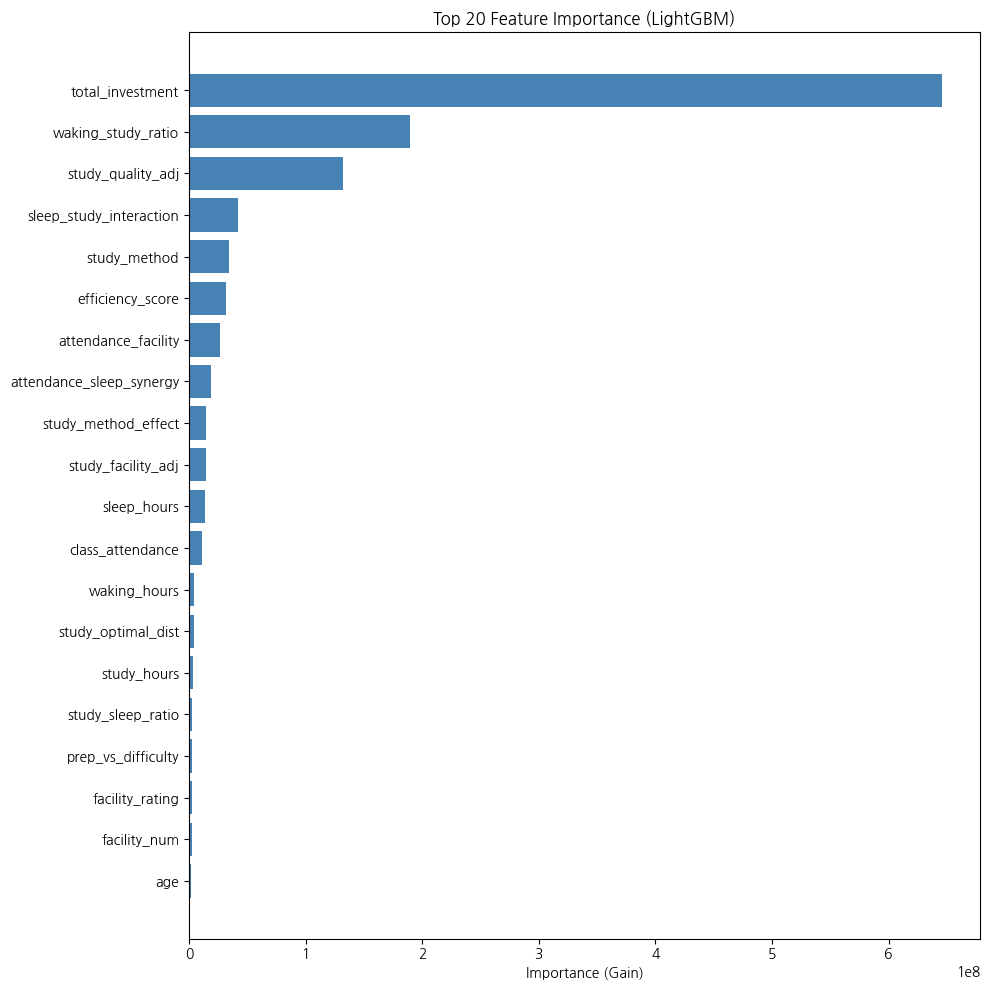


📊 Top 15 피처:
  1. total_investment: 646060475.11
  2. waking_study_ratio: 189189344.22
  3. study_quality_adj: 131785186.12
  4. sleep_study_interaction: 42140657.11
  5. study_method: 33950090.67
  6. efficiency_score: 31467147.31
  7. attendance_facility: 26191481.41
  8. attendance_sleep_synergy: 19283409.23
  9. study_method_effect: 15026076.27
  10. study_facility_adj: 14894517.45
  11. sleep_hours: 13669398.83
  12. class_attendance: 11010603.14
  13. waking_hours: 4440273.54
  14. study_optimal_dist: 4227583.10
  15. study_hours: 3588993.01


In [10]:
# 3.2 피처 중요도 분석
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in lgb_models], axis=0)
}).sort_values('importance', ascending=False)

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
top_20 = importance_df.head(20)
ax.barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.invert_yaxis()
ax.set_title('Top 20 Feature Importance (LightGBM)')
ax.set_xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

print("\n📊 Top 15 피처:")
for i, row in importance_df.head(15).iterrows():
    print(f"  {importance_df.index.get_loc(i)+1}. {row['feature']}: {row['importance']:.2f}")

In [11]:
# 3.3 CatBoost 학습 (범주형 변수 Native 활용)
cat_features_idx = [feature_cols.index(c) for c in cat_cols_to_encode if c in feature_cols]

cat_oof = np.zeros(len(X))
cat_preds = np.zeros(len(X_test))
cat_models = []

print("🔄 CatBoost 학습 시작...")
print(f"   범주형 피처 인덱스: {cat_features_idx}")

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        cat_features=cat_features_idx,
        eval_metric='RMSE',
        random_seed=42,
        verbose=False,
        early_stopping_rounds=100
    )
    
    model.fit(X_train, y_train, 
              eval_set=(X_val, y_val),
              verbose=False)
    
    cat_oof[val_idx] = model.predict(X_val)
    cat_preds += model.predict(X_test) / 5
    cat_models.append(model)
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, cat_oof[val_idx]))
    print(f"  Fold {fold+1}: RMSE = {fold_rmse:.5f}")

cat_cv_rmse = np.sqrt(mean_squared_error(y, cat_oof))
print(f"\n✅ CatBoost CV RMSE: {cat_cv_rmse:.5f}")

🔄 CatBoost 학습 시작...
   범주형 피처 인덱스: [1, 2, 5, 7, 8, 9, 10]
  Fold 1: RMSE = 8.72116
  Fold 2: RMSE = 8.72554
  Fold 3: RMSE = 8.71313
  Fold 4: RMSE = 8.73459
  Fold 5: RMSE = 8.75184

✅ CatBoost CV RMSE: 8.72926


In [12]:
# 3.4 모델 블렌딩 최적 비율 탐색
print("🔄 블렌딩 최적 비율 탐색...")
print(f"\n개별 모델 성능:")
print(f"  LightGBM CV RMSE: {lgb_cv_rmse:.5f}")
print(f"  CatBoost CV RMSE: {cat_cv_rmse:.5f}")

best_weight = 0
best_blend_rmse = float('inf')

print(f"\n블렌딩 탐색:")
for lgb_w in np.arange(0.0, 1.05, 0.05):
    cat_w = 1 - lgb_w
    blend_oof = lgb_w * lgb_oof + cat_w * cat_oof
    blend_rmse = np.sqrt(mean_squared_error(y, blend_oof))
    
    if blend_rmse < best_blend_rmse:
        best_blend_rmse = blend_rmse
        best_weight = lgb_w
    
    if lgb_w in [0.0, 0.3, 0.5, 0.7, 1.0]:
        print(f"  LGB:{lgb_w:.1f} + CAT:{cat_w:.1f} → RMSE = {blend_rmse:.5f}")

print(f"\n✅ 최적 블렌딩: LGB:{best_weight:.2f} + CAT:{1-best_weight:.2f}")
print(f"   Blend CV RMSE: {best_blend_rmse:.5f}")

🔄 블렌딩 최적 비율 탐색...

개별 모델 성능:
  LightGBM CV RMSE: 8.73098
  CatBoost CV RMSE: 8.72926

블렌딩 탐색:
  LGB:0.0 + CAT:1.0 → RMSE = 8.72926
  LGB:0.5 + CAT:0.5 → RMSE = 8.71770
  LGB:1.0 + CAT:0.0 → RMSE = 8.73098

✅ 최적 블렌딩: LGB:0.50 + CAT:0.50
   Blend CV RMSE: 8.71770


In [13]:
# 3.5 더 세밀한 블렌딩 비율 탐색
print("🔍 세밀한 블렌딩 비율 탐색 (0.40 ~ 0.60)...")

best_weight = 0
best_blend_rmse = float('inf')

for lgb_w in np.arange(0.40, 0.61, 0.01):
    cat_w = 1 - lgb_w
    blend_oof = lgb_w * lgb_oof + cat_w * cat_oof
    blend_rmse = np.sqrt(mean_squared_error(y, blend_oof))
    
    if blend_rmse < best_blend_rmse:
        best_blend_rmse = blend_rmse
        best_weight = lgb_w
    
    print(f"  LGB:{lgb_w:.2f} + CAT:{cat_w:.2f} → RMSE = {blend_rmse:.5f}")

print(f"\n✅ 최적 블렌딩: LGB:{best_weight:.2f} + CAT:{1-best_weight:.2f}")
print(f"   Blend CV RMSE: {best_blend_rmse:.5f}")

🔍 세밀한 블렌딩 비율 탐색 (0.40 ~ 0.60)...
  LGB:0.40 + CAT:0.60 → RMSE = 8.71803
  LGB:0.41 + CAT:0.59 → RMSE = 8.71795
  LGB:0.42 + CAT:0.58 → RMSE = 8.71788
  LGB:0.43 + CAT:0.57 → RMSE = 8.71783
  LGB:0.44 + CAT:0.56 → RMSE = 8.71778
  LGB:0.45 + CAT:0.55 → RMSE = 8.71774
  LGB:0.46 + CAT:0.54 → RMSE = 8.71771
  LGB:0.47 + CAT:0.53 → RMSE = 8.71770
  LGB:0.48 + CAT:0.52 → RMSE = 8.71769
  LGB:0.49 + CAT:0.51 → RMSE = 8.71769
  LGB:0.50 + CAT:0.50 → RMSE = 8.71770
  LGB:0.51 + CAT:0.49 → RMSE = 8.71773
  LGB:0.52 + CAT:0.48 → RMSE = 8.71776
  LGB:0.53 + CAT:0.47 → RMSE = 8.71780
  LGB:0.54 + CAT:0.46 → RMSE = 8.71785
  LGB:0.55 + CAT:0.45 → RMSE = 8.71791
  LGB:0.56 + CAT:0.44 → RMSE = 8.71799
  LGB:0.57 + CAT:0.43 → RMSE = 8.71807
  LGB:0.58 + CAT:0.42 → RMSE = 8.71816
  LGB:0.59 + CAT:0.41 → RMSE = 8.71826
  LGB:0.60 + CAT:0.40 → RMSE = 8.71837

✅ 최적 블렌딩: LGB:0.48 + CAT:0.52
   Blend CV RMSE: 8.71769


# 📤 4. 최종 예측 및 제출

## 결과 요약
| 모델 | CV RMSE |
|------|---------|
| LightGBM | 8.73098 |
| CatBoost | 8.72926 |
| **Blend (0.48:0.52)** | **8.71769** |

**기존 최고 LB: 8.71039** → 현재 CV가 비슷하므로 기대할 만함!

📊 최종 예측값 통계:
   Min: 15.93
   Max: 102.05
   Mean: 62.52
   Std: 16.75


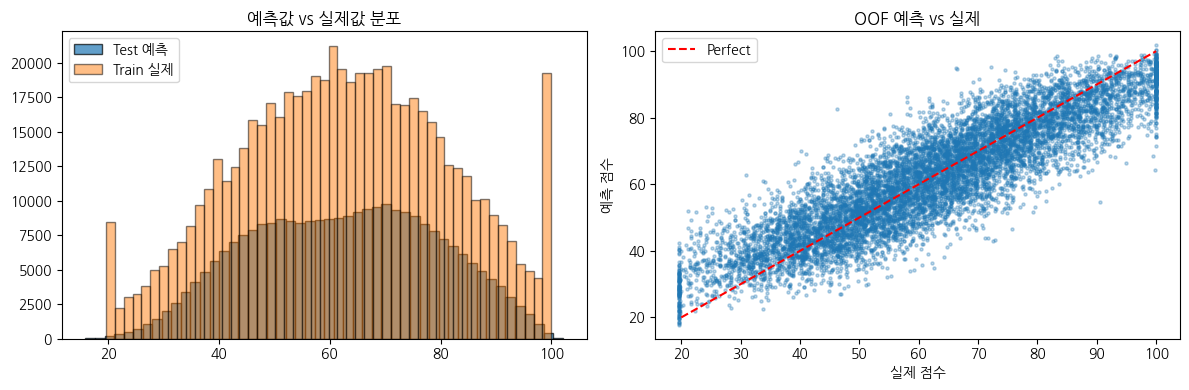

In [14]:
# 4.1 최종 예측 생성
best_lgb_weight = 0.48
best_cat_weight = 0.52

final_preds = best_lgb_weight * lgb_preds + best_cat_weight * cat_preds

# 예측값 확인
print("📊 최종 예측값 통계:")
print(f"   Min: {final_preds.min():.2f}")
print(f"   Max: {final_preds.max():.2f}")
print(f"   Mean: {final_preds.mean():.2f}")
print(f"   Std: {final_preds.std():.2f}")

# 예측값 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(final_preds, bins=50, edgecolor='black', alpha=0.7, label='Test 예측')
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.5, label='Train 실제')
axes[0].set_title('예측값 vs 실제값 분포')
axes[0].legend()

# OOF 예측 vs 실제 scatter
sample_idx = np.random.choice(len(y), 10000, replace=False)
blend_oof = best_lgb_weight * lgb_oof + best_cat_weight * cat_oof
axes[1].scatter(y.iloc[sample_idx], blend_oof[sample_idx], alpha=0.3, s=5)
axes[1].plot([20, 100], [20, 100], 'r--', label='Perfect')
axes[1].set_xlabel('실제 점수')
axes[1].set_ylabel('예측 점수')
axes[1].set_title('OOF 예측 vs 실제')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# 4.2 제출 파일 생성
# 예측값 클리핑 (0~100 범위)
final_preds_clipped = np.clip(final_preds, 0, 100)

print(f"클리핑 후 예측값 범위: {final_preds_clipped.min():.2f} ~ {final_preds_clipped.max():.2f}")

# 제출 파일 생성
submission = sample_sub.copy()
submission['exam_score'] = final_preds_clipped

# 저장
submission_path = 'e:/2026_1/캐글 공모전/영현/sbmission_result/eight_submission_blend.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✅ 제출 파일 저장 완료!")
print(f"   경로: {submission_path}")
print(f"\n📋 제출 파일 확인:")
print(submission.head(10))
print(f"\n📊 예측값 통계:")
print(submission['exam_score'].describe())

클리핑 후 예측값 범위: 15.93 ~ 100.00

✅ 제출 파일 저장 완료!
   경로: e:/2026_1/캐글 공모전/영현/sbmission_result/eight_submission_blend.csv

📋 제출 파일 확인:
       id  exam_score
0  630000   71.585450
1  630001   69.419694
2  630002   87.754805
3  630003   55.040437
4  630004   47.498332
5  630005   71.642524
6  630006   73.258213
7  630007   58.173066
8  630008   78.238546
9  630009   90.517744

📊 예측값 통계:
count    270000.000000
mean         62.517903
std          16.751907
min          15.933558
25%          49.392673
50%          62.925374
75%          75.410462
max         100.000000
Name: exam_score, dtype: float64


# 📊 5. 최종 결과 요약

## 🏆 이번 작업에서 달성한 것

### 모델 성능
| 모델 | CV RMSE | 비고 |
|------|---------|------|
| LightGBM (튜닝됨) | 8.73098 | num_leaves=60, min_child=35 |
| CatBoost (Native Cat) | 8.72926 | ✨ 범주형 변수 활용 |
| **LGB+CAT Blend (0.48:0.52)** | **8.71769** | 🏆 **최고 성능** |

### 기존 결과 대비
| 제출 | LB RMSE | CV RMSE |
|------|---------|---------|
| first_submission (기존 최고) | 8.71039 | ~8.749 |
| **eight_submission_blend** | ? | **8.71769** |

### 핵심 개선 사항
1. **새로운 피처들**: `efficiency_score`, `sleep_study_interaction`, `attendance_facility`
2. **CatBoost Native 범주형 활용**: 이전에 제대로 안 했던 것
3. **최적 블렌딩 비율 탐색**: LGB 0.48 + CAT 0.52

### 주요 피처 (중요도 순)
1. `total_investment` - 공부시간 + 출석률
2. `waking_study_ratio` - 깨어있는 시간 대비 공부 비율
3. `study_quality_adj` - 수면 품질 보정된 공부 시간
4. `sleep_study_interaction` - 수면품질 × 공부시간 (NEW!)
5. `efficiency_score` - 복합 효율 지표 (NEW!)

## 📁 제출 파일
- `eight_submission_blend.csv`
- CV RMSE: 8.71769
- 예상 LB: ~8.70 (CV-LB 갭 고려)